In [2]:
# ---Imports + settings---
import pandas as pd
import numpy as np
from pathlib import Path
import joblib
import shap
import matplotlib.pyplot as plt


In [3]:
# ---Load model + load data---
PROJECT_ROOT = Path.cwd().parent
MODEL_PATH = PROJECT_ROOT / "models" / "xgb_pipeline.joblib"
DATA_PATH = PROJECT_ROOT / "data" / "raw" / "diabetic_data.csv"

clf_xgb = joblib.load(MODEL_PATH)

df = pd.read_csv(DATA_PATH).replace("?", np.nan)
df["target_readmit_30"] = (df["readmitted"] == "<30").astype(int)

DROP_COLS = ["readmitted", "encounter_id"]
TARGET_COL = "target_readmit_30"
GROUP_COL = "patient_nbr"


In [4]:
# ---Recreate the Modeling Feature Set for SHAP Analysis---
X = df.drop(columns=DROP_COLS + [TARGET_COL, GROUP_COL])

# Drop the same columns you dropped in Step 2 (if present)
cols_to_drop = [c for c in ["weight", "payer_code", "medical_specialty"] if c in X.columns]
X = X.drop(columns=cols_to_drop)

X.shape


(101766, 44)

In [5]:
# ---Get feature names after preprocessing---
preprocess = clf_xgb.named_steps["prep"]
model = clf_xgb.named_steps["model"]

feature_names = preprocess.get_feature_names_out()
len(feature_names), feature_names[:10]


(2280,
 array(['num__admission_type_id', 'num__discharge_disposition_id',
        'num__admission_source_id', 'num__time_in_hospital',
        'num__num_lab_procedures', 'num__num_procedures',
        'num__num_medications', 'num__number_outpatient',
        'num__number_emergency', 'num__number_inpatient'], dtype=object))

In [6]:
# ---Create a SHAP background + explain a subset---
# Use a subset so this runs quickly
X_sample = X.sample(2000, random_state=42)

X_trans = preprocess.transform(X_sample)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_trans)

# shap_values shape: (n_samples, n_features)
np.shape(shap_values)


(2000, 2280)

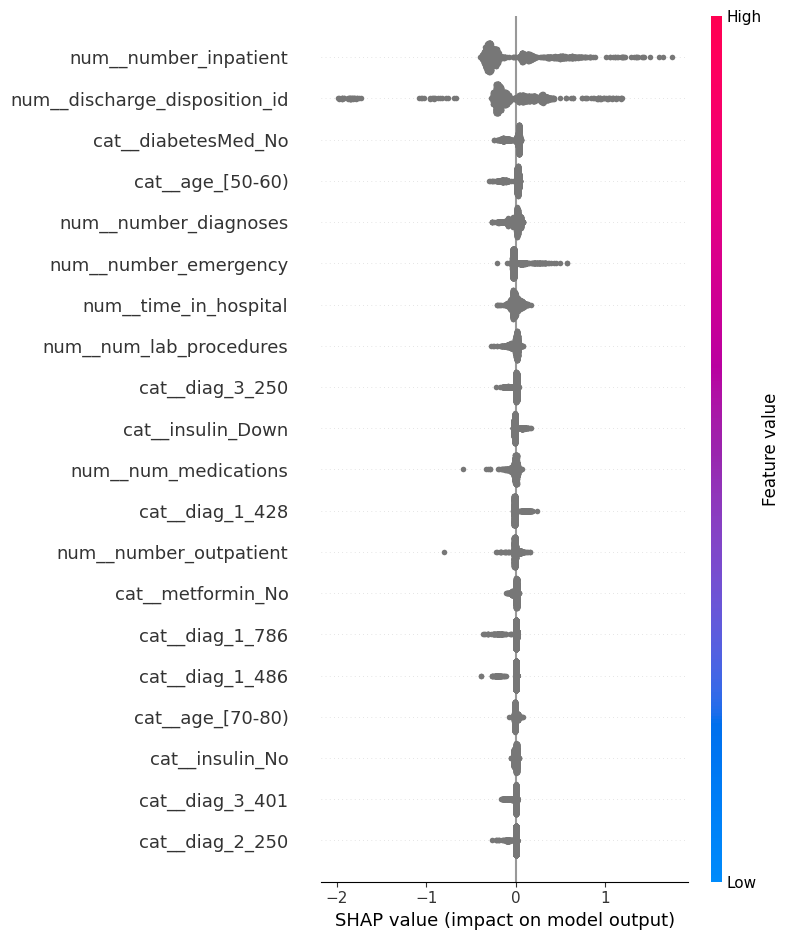

In [7]:
# ---Global importance plot (top drivers)---
shap.summary_plot(
    shap_values,
    X_trans,
    feature_names=feature_names,
    max_display=20,
    show=False
)
plt.tight_layout()
plt.show()


In [8]:
# ---Save a few demo rows for the Streamlit app---
OUT_DIR = PROJECT_ROOT / "data" / "processed"
OUT_DIR.mkdir(parents=True, exist_ok=True)

demo_rows = X_sample.head(200).copy()
demo_rows.to_csv(OUT_DIR / "demo_patients.csv", index=False)

print("Saved:", OUT_DIR / "demo_patients.csv")


Saved: c:\Users\shahz\OneDrive\Desktop\Folders\Clinical-Risk-Prediciton\data\processed\demo_patients.csv
